In [1]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
data_path = kagglehub.competition_download('nlp-getting-started')

print('Data source import complete.')

100%|██████████| 593k/593k [00:00<00:00, 719kB/s]

Extracting files...
Data source import complete.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
data = pd.read_csv(os.path.join(data_path, 'train.csv'))
test_data = pd.read_csv(os.path.join(data_path, 'test.csv'))

# EDA

In [6]:
data.shape

(7613, 5)

In [7]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Example of what is not disaster tweet

In [8]:
data[data["target"] == 0]["text"].values[10]

"No way...I can't eat that shit"

Example of what is disaster tweet

In [9]:
data[data["target"] == 1]["text"].values[10]

'Three people died from the heat wave so far'

In [10]:
missing_table = pd.DataFrame({
    'Missing Values': data.isna().sum(),
    'Percentage (%)': (data.isnull().mean() * 100).round(2)
})

print(missing_table.sort_values(by='Missing Values', ascending=False))

          Missing Values  Percentage (%)
location            2533           33.27
keyword               61            0.80
id                     0            0.00
text                   0            0.00
target                 0            0.00


In [11]:
data.nunique()

,0
id,7613
keyword,221
location,3341
text,7503
target,2


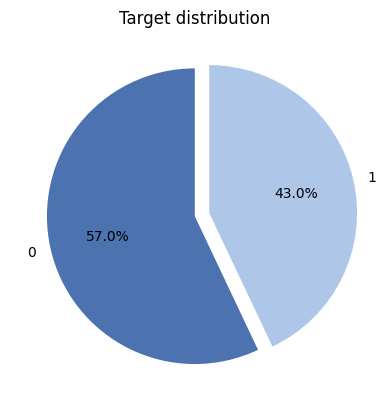

In [12]:
data['target'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, explode=(0,0.1), colors=['#4c72b0', '#aec7e8'])
plt.title('Target distribution')
plt.ylabel('')
plt.show()

# Data preprocesing

In [13]:
from sklearn.model_selection import train_test_split

Cleaning the data

In [14]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text) # urls
    text = re.sub(r'@\w+', '', text) # mentions
    text = re.sub(r'#\w+', '', text) # hashtags
    text = re.sub(r'[^\w\s]', '', text) # non-word and non-whitespace characters
    text = re.sub(r'\d+', '', text) # digits
    text = re.sub(r'\s+', ' ', text).strip() # normalize whitespace

    return text

In [15]:
# data['text'] = data['text'].apply(clean_text)
# test_data['text'] = test_data['text'].apply(clean_text)

In [16]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Vectorization

In [18]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(max_features=10000,
#                         ngram_range=(1, 2),
#                         min_df=2,
#                         stop_words='english')

# train_vectors = tfidf.fit_transform(data["text"])
# test_vectors = tfidf.transform(test_data["text"])

In [19]:
X = data.drop('target', axis=1)
y = data['target']

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Model building

In [21]:
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_score
from sklearn.linear_model import RidgeClassifier, LogisticRegression
import torch
import torch.nn as nn
import transformers
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss, BCELoss
from collections import Counter
from transformers import AutoModel, AutoTokenizer

In [22]:
# model_class, tokenizer_class, pretrained_weights = (transformers.BertModel , transformers.BertTokenizer, 'bert-large-uncased')
# tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
# bert_model = model_class.from_pretrained(pretrained_weights)

In [23]:
bert_model = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [24]:
for param in bert_model.parameters():
    param.requires_grad = True

In [25]:
X_train_token = tokenizer(X_train["text"].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)
X_val_token = tokenizer(X_val["text"].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)

In [26]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        if labels is not None:
          self.labels = list(labels)
        else:
          self.labels = None

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        if self.labels is not None:
          item["labels"] = torch.tensor(self.labels[idx])
        return item

In [27]:
train_dataset = TweetDataset(X_train_token, y_train)
val_dataset = TweetDataset(X_val_token, y_val)

In [28]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [29]:
class Tweetmodel(nn.Module):
  def __init__(self, bert_model, hidden_dim, output_dim):
    super(Tweetmodel, self).__init__()
    self.bert = bert_model
    embedding_dim = bert_model.config.hidden_size

    self.out = nn.Sequential(
        # nn.Linear(embedding_dim, hidden_dim),
        nn.Dropout(0.3),
        nn.Linear(embedding_dim, output_dim)
        )

  def forward(self, input_ids, attn_mask):
    bert_output = self.bert(input_ids=input_ids, attention_mask=attn_mask)
    output = bert_output.last_hidden_state[:, 0, :]
    output = self.out(output)
    return output

In [30]:
model = Tweetmodel(bert_model, hidden_dim=128, output_dim=1)

In [31]:
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2, eps = 1e-7)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

counter = Counter(y)
weights = torch.tensor([counter[0] / counter[1]], dtype=torch.float).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=weights)

In [32]:
for epoch in range(8):
    model.train()
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].unsqueeze(1).float().to(device)

        outputs = model(input_ids=input_ids, attn_mask=attention_mask)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch+1} complete")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].unsqueeze(1).float().to(device)

            outputs = model(input_ids=input_ids, attn_mask=attention_mask)
            probs = torch.sigmoid(outputs)
            preds = torch.round(probs)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Validation Accuracy: {(correct / total) * 100:.2f}%")

Epoch 1 complete
Validation Accuracy: 83.19%
Epoch 2 complete
Validation Accuracy: 84.44%
Epoch 3 complete
Validation Accuracy: 81.55%
Epoch 4 complete
Validation Accuracy: 82.67%
Epoch 5 complete
Validation Accuracy: 83.65%
Epoch 6 complete
Validation Accuracy: 81.68%
Epoch 7 complete
Validation Accuracy: 83.26%
Epoch 8 complete
Validation Accuracy: 83.19%


# Submission

In [33]:
test_token = tokenizer(test_data["text"].tolist(), return_tensors='pt', padding=True, truncation=True)

In [34]:
test_dataset = TweetDataset(test_token)
test_loader = DataLoader(test_dataset, batch_size=16)

In [35]:
model.eval()
predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attn_mask=attention_mask)
        probs = torch.sigmoid(outputs)
        preds = torch.round(probs)
        predictions.extend(preds.squeeze().cpu().numpy().astype(int))

In [36]:
submission = pd.DataFrame({
    'id': test_data["id"],
    'target': predictions
})

In [37]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [38]:
submission.to_csv('submission.csv', index=False)